In [9]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed_W2.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [10]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed_W2.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

# drop uncorrelated features
#weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [11]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

In [12]:
weather_data

,Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h),official_holiday,legally_not_recongnized_holidays,event_day,weekend
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,
2021-01-01 00:00:00,0.0,7.2,79.0,9.0,1,0,0,0
2021-01-01 01:00:00,0.0,7.3,79.0,6.0,1,0,0,0
2021-01-01 02:00:00,0.0,7.6,78.0,4.0,1,0,0,0
2021-01-01 03:00:00,0.0,8.2,75.0,4.0,1,0,0,0
2021-01-01 04:00:00,0.0,7.7,77.0,7.0,1,0,0,0
...,...,...,...,...,...,...,...,...
2022-11-06 19:00:00,0.0,13.9,51.0,28.0,0,0,0,1
2022-11-06 20:00:00,0.0,13.2,53.0,22.0,0,0,0,1
2022-11-06 21:00:00,0.0,13.2,57.0,29.0,0,0,0,1


In [13]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-10-17'
end = '2022-10-30'

# make feature time series dataframe
tseriesX_df = weather_data.sort_index().copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

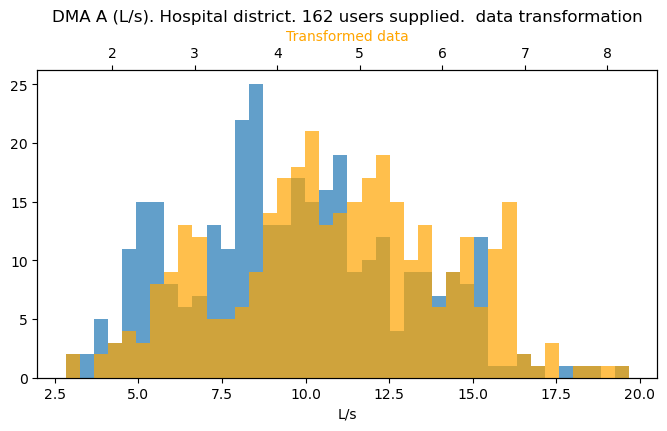

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07979D+00    |proj g|=  3.40304D-01


 This problem is unconstrained.



At iterate    5    f=  1.04120D+00    |proj g|=  3.00697D-01

At iterate   10    f=  1.01753D+00    |proj g|=  5.26572D-02

At iterate   15    f=  1.00693D+00    |proj g|=  3.20236D-02

At iterate   20    f=  1.00145D+00    |proj g|=  6.14779D-02

At iterate   25    f=  1.00008D+00    |proj g|=  6.34255D-02

At iterate   30    f=  9.99608D-01    |proj g|=  3.62071D-02

At iterate   35    f=  9.98755D-01    |proj g|=  5.87487D-03

At iterate   40    f=  9.98573D-01    |proj g|=  2.39591D-03

At iterate   45    f=  9.98512D-01    |proj g|=  2.00216D-03

At iterate   50    f=  9.98395D-01    |proj g|=  5.34494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

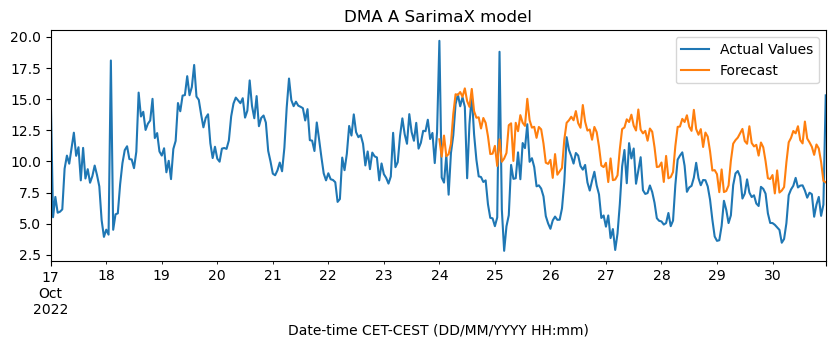

Performance indicators
DMA A SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.92            7.91             3.93           14.76 

Performance indicators


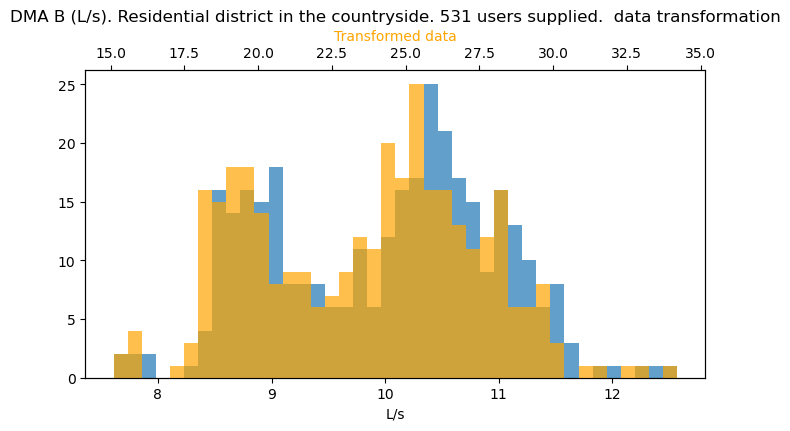

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58993D+00    |proj g|=  3.98601D-01


 This problem is unconstrained.



At iterate    5    f=  1.58195D+00    |proj g|=  7.54927D-02

At iterate   10    f=  1.57934D+00    |proj g|=  3.86457D-02

At iterate   15    f=  1.57505D+00    |proj g|=  8.37710D-02

At iterate   20    f=  1.56941D+00    |proj g|=  6.87553D-02

At iterate   25    f=  1.56467D+00    |proj g|=  1.35129D-01

At iterate   30    f=  1.55979D+00    |proj g|=  3.60541D-02

At iterate   35    f=  1.55882D+00    |proj g|=  5.62084D-02

At iterate   40    f=  1.55840D+00    |proj g|=  6.39150D-03

At iterate   45    f=  1.55823D+00    |proj g|=  2.12671D-02

At iterate   50    f=  1.55758D+00    |proj g|=  9.30223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

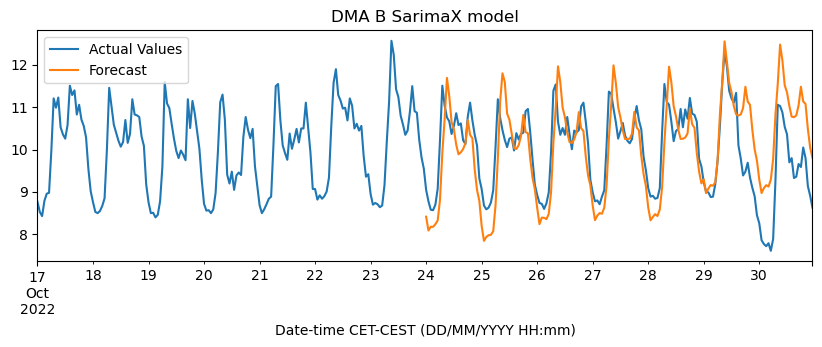

Performance indicators
DMA B SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.61            1.59             0.67           2.87 

Performance indicators


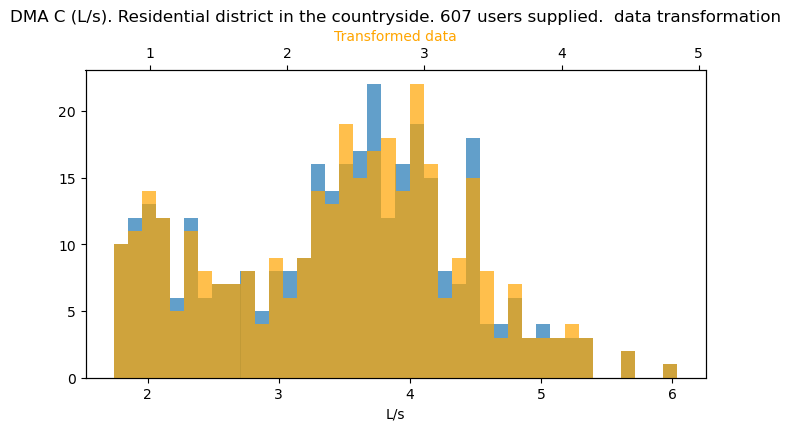

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.44513D-01    |proj g|=  1.15139D+00


 This problem is unconstrained.



At iterate    5    f=  4.61277D-01    |proj g|=  3.81488D-01

At iterate   10    f=  3.09246D-01    |proj g|=  1.02418D+00

At iterate   15    f=  2.61055D-01    |proj g|=  2.00147D-01

At iterate   20    f=  2.52755D-01    |proj g|=  4.82987D-01

At iterate   25    f=  2.49532D-01    |proj g|=  6.39994D-02

At iterate   30    f=  2.48305D-01    |proj g|=  2.05986D-02

At iterate   35    f=  2.47761D-01    |proj g|=  6.01196D-02

At iterate   40    f=  2.47259D-01    |proj g|=  4.13047D-02

At iterate   45    f=  2.47082D-01    |proj g|=  2.90657D-02

At iterate   50    f=  2.47039D-01    |proj g|=  4.09812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

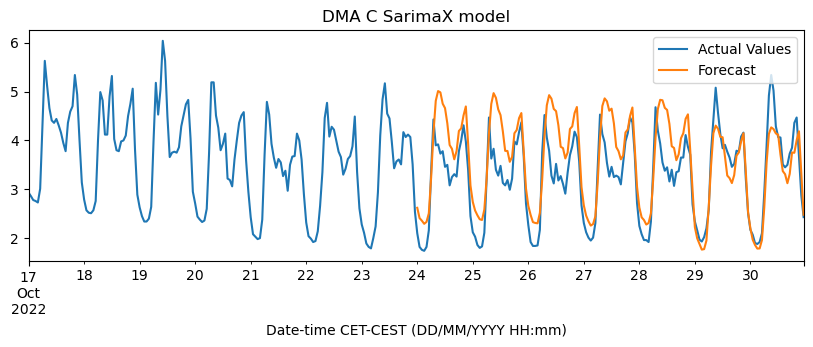

Performance indicators
DMA C SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.62            1.25             0.47           2.34 

Performance indicators


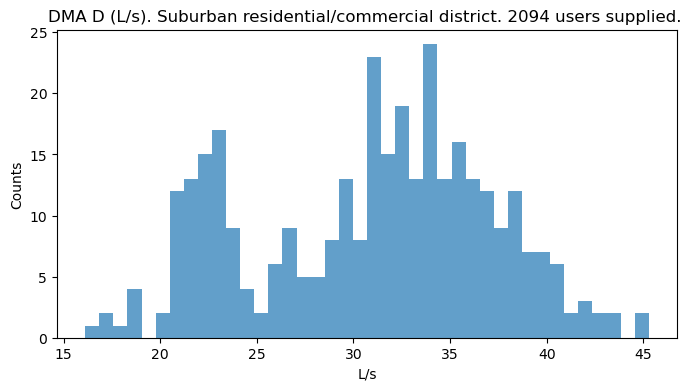

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14705D+00    |proj g|=  3.40426D-01


 This problem is unconstrained.



At iterate    5    f=  2.03575D+00    |proj g|=  1.04983D-01

At iterate   10    f=  2.00842D+00    |proj g|=  1.14344D-02

At iterate   15    f=  2.00677D+00    |proj g|=  1.23075D-02

At iterate   20    f=  2.00594D+00    |proj g|=  6.73790D-03

At iterate   25    f=  2.00517D+00    |proj g|=  1.58989D-02

At iterate   30    f=  2.00458D+00    |proj g|=  8.02930D-03

At iterate   35    f=  2.00447D+00    |proj g|=  2.92960D-03

At iterate   40    f=  2.00442D+00    |proj g|=  4.39075D-03

At iterate   45    f=  2.00414D+00    |proj g|=  8.74892D-03

At iterate   50    f=  2.00396D+00    |proj g|=  8.96282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

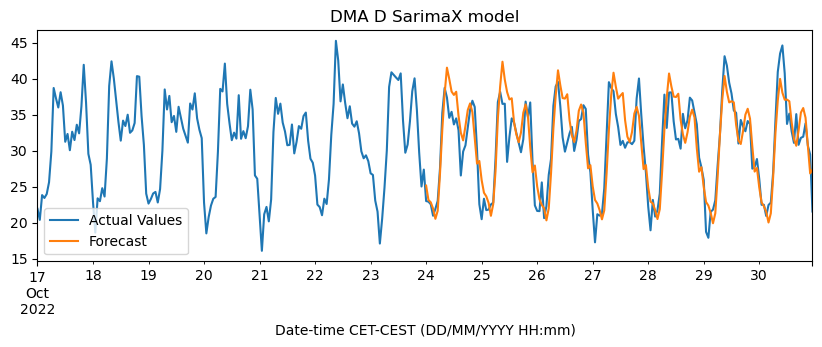

Performance indicators
DMA D SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.48            6.01             2.55           11.04 



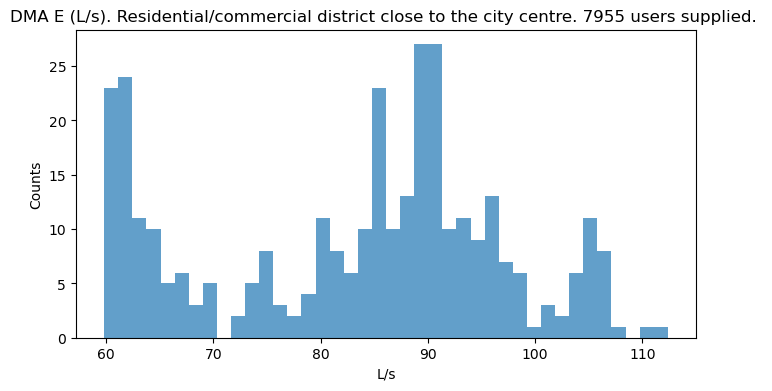

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96676D+00    |proj g|=  3.52707D-01


 This problem is unconstrained.



At iterate    5    f=  1.88359D+00    |proj g|=  2.34216D-01

At iterate   10    f=  1.86947D+00    |proj g|=  1.59020D-02

At iterate   15    f=  1.86072D+00    |proj g|=  7.64625D-02

At iterate   20    f=  1.85420D+00    |proj g|=  1.45963D-02

At iterate   25    f=  1.85110D+00    |proj g|=  2.57114D-02

At iterate   30    f=  1.84919D+00    |proj g|=  7.33494D-02

At iterate   35    f=  1.84659D+00    |proj g|=  1.42020D-01

At iterate   40    f=  1.84489D+00    |proj g|=  7.55275D-03

At iterate   45    f=  1.84464D+00    |proj g|=  3.40281D-03

At iterate   50    f=  1.84442D+00    |proj g|=  1.60949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

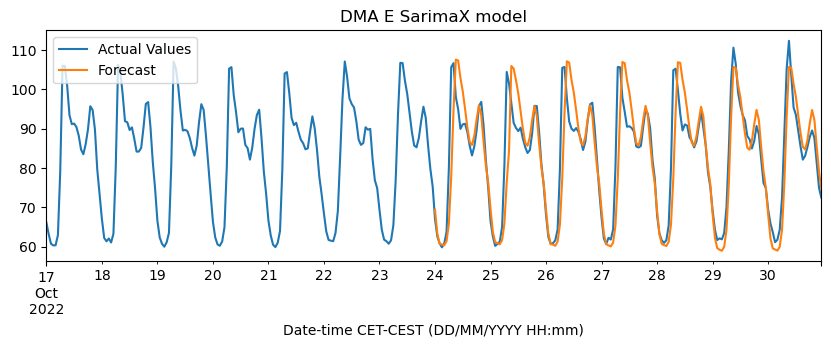

Performance indicators
DMA E SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.35            27.89             4.82           38.05 



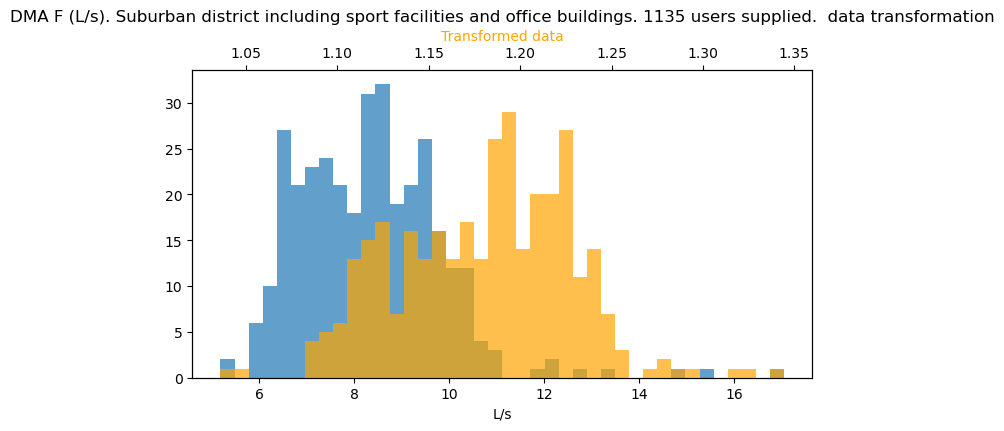

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77694D+00    |proj g|=  1.39668D+01


 This problem is unconstrained.



At iterate    5    f= -1.78706D+00    |proj g|=  9.95690D-01

At iterate   10    f= -1.78796D+00    |proj g|=  1.41958D+00

At iterate   15    f= -1.78809D+00    |proj g|=  4.06139D+00

At iterate   20    f= -1.78899D+00    |proj g|=  6.99210D-01

At iterate   25    f= -1.78902D+00    |proj g|=  1.74387D-01

At iterate   30    f= -1.78952D+00    |proj g|=  5.34431D+00

At iterate   35    f= -1.79368D+00    |proj g|=  3.75309D+00

At iterate   40    f= -1.79407D+00    |proj g|=  1.82568D-01

At iterate   45    f= -1.79411D+00    |proj g|=  8.99100D-02

At iterate   50    f= -1.79413D+00    |proj g|=  2.42517D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

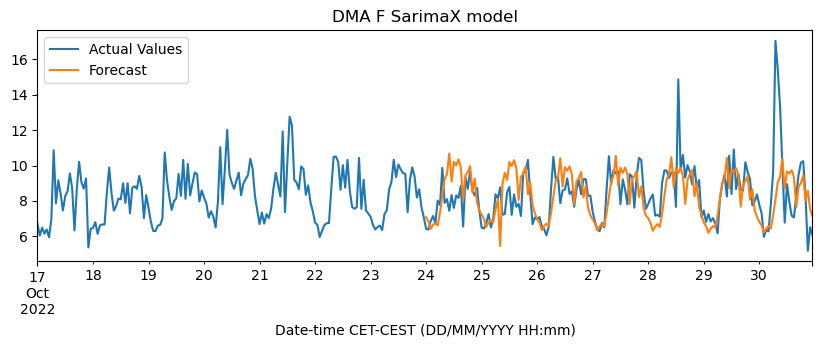

Performance indicators
DMA F SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.02            3.24             1.08           5.34 

Performance indicators


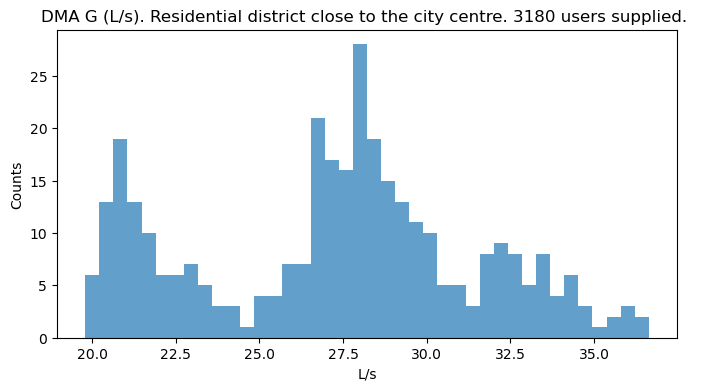

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55375D+00    |proj g|=  6.85426D-01


 This problem is unconstrained.



At iterate    5    f=  1.35039D+00    |proj g|=  1.39207D-01

At iterate   10    f=  1.33277D+00    |proj g|=  2.69186D-02

At iterate   15    f=  1.33096D+00    |proj g|=  2.35503D-02

At iterate   20    f=  1.32921D+00    |proj g|=  3.77462D-02

At iterate   25    f=  1.32548D+00    |proj g|=  3.29554D-02

At iterate   30    f=  1.32515D+00    |proj g|=  3.95057D-03

At iterate   35    f=  1.32508D+00    |proj g|=  9.47356D-03

At iterate   40    f=  1.32472D+00    |proj g|=  1.18184D-02

At iterate   45    f=  1.32457D+00    |proj g|=  6.91992D-03

At iterate   50    f=  1.32449D+00    |proj g|=  3.35973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

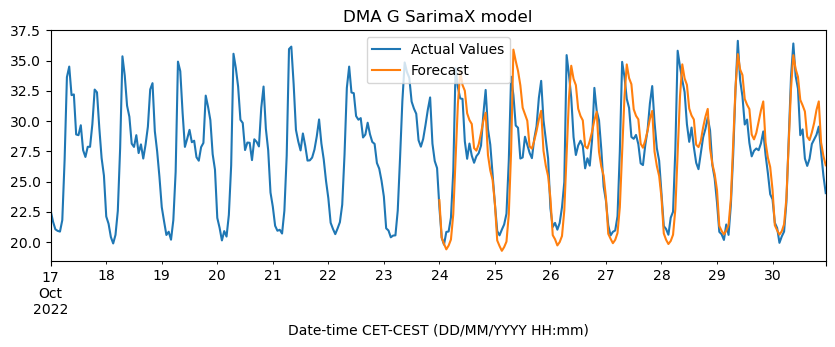

Performance indicators
DMA G SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.83            7.55             1.83           11.21 



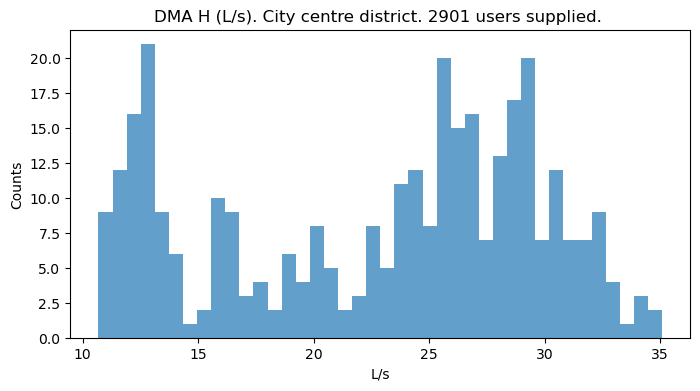

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68601D+00    |proj g|=  4.12463D-01


 This problem is unconstrained.



At iterate    5    f=  1.60274D+00    |proj g|=  1.82347D-02

At iterate   10    f=  1.60073D+00    |proj g|=  1.36216D-02

At iterate   15    f=  1.59215D+00    |proj g|=  2.92269D-02

At iterate   20    f=  1.58831D+00    |proj g|=  2.84800D-02

At iterate   25    f=  1.58622D+00    |proj g|=  1.39290D-02

At iterate   30    f=  1.58417D+00    |proj g|=  2.44844D-02

At iterate   35    f=  1.58189D+00    |proj g|=  1.65335D-02

At iterate   40    f=  1.58025D+00    |proj g|=  7.27197D-02

At iterate   45    f=  1.57906D+00    |proj g|=  2.08979D-02

At iterate   50    f=  1.57842D+00    |proj g|=  2.46403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

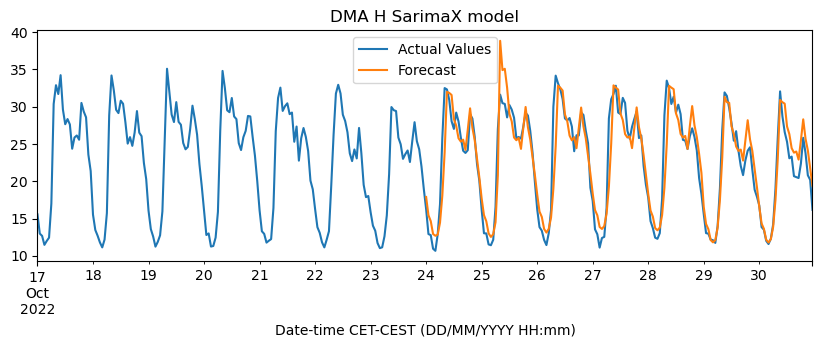

Performance indicators
DMA H SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.99            8.61             1.91           12.52 



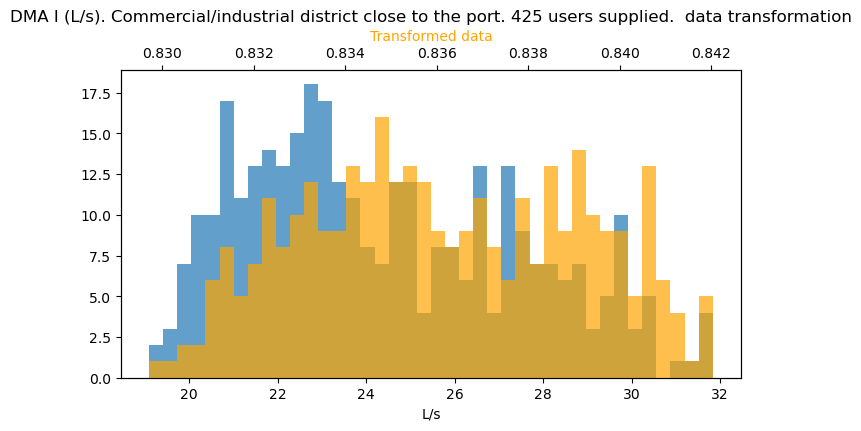

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.25766D+00    |proj g|=  5.81630D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      5     82      3     0     0   9.217D+01  -4.259D+00
  F =  -4.2588726478483592     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


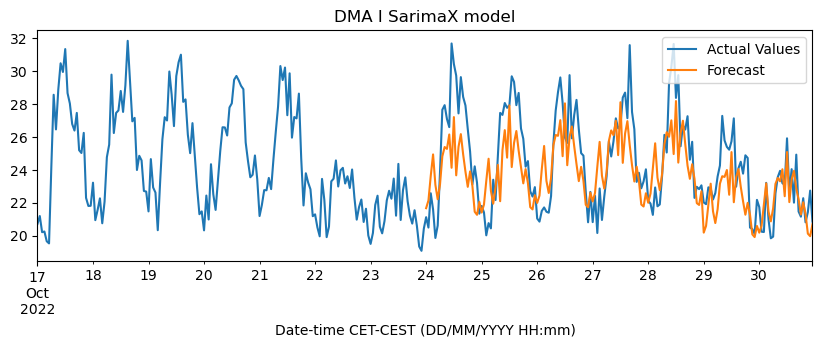

Performance indicators
DMA I SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.49            7.54             1.63           11.65 

Performance indicators


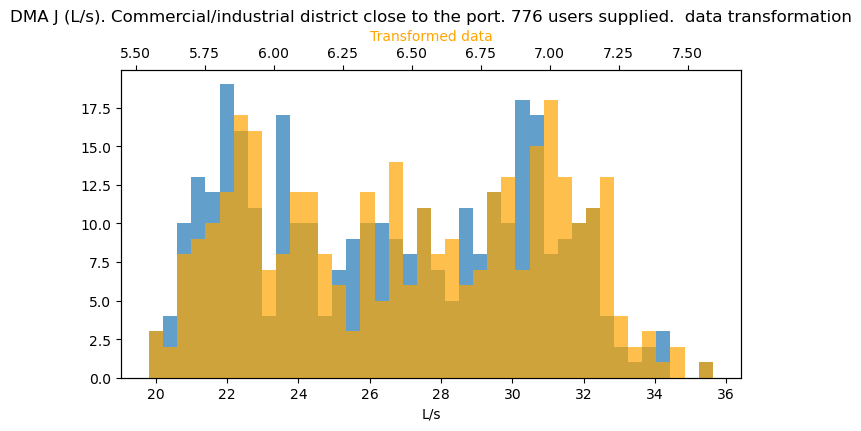

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.86113D-02    |proj g|=  3.63054D+00


 This problem is unconstrained.



At iterate    5    f= -6.08905D-02    |proj g|=  1.70780D+00

At iterate   10    f= -9.25739D-02    |proj g|=  6.37784D-01

At iterate   15    f= -9.56436D-02    |proj g|=  1.23506D-01

At iterate   20    f= -9.68547D-02    |proj g|=  2.85047D-02

At iterate   25    f= -9.72538D-02    |proj g|=  9.08006D-02

At iterate   30    f= -9.75477D-02    |proj g|=  2.48933D-02

At iterate   35    f= -9.78789D-02    |proj g|=  7.41863D-02

At iterate   40    f= -9.79396D-02    |proj g|=  2.23723D-02

At iterate   45    f= -9.81624D-02    |proj g|=  8.54467D-02

At iterate   50    f= -9.82748D-02    |proj g|=  4.46105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

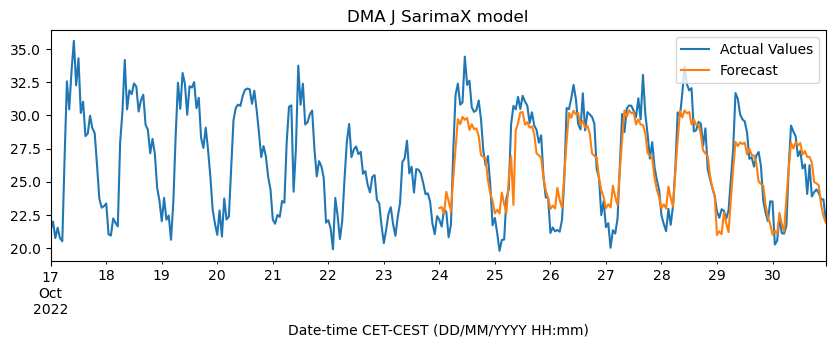

Performance indicators
DMA J SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.86            4.76             1.31           7.93 

Performance indicators


In [14]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

i = 0
# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data.sort_index()[dma][start:end].copy()

    ## data transformation
    if dma not in ['DMA D (L/s)','DMA E (L/s)','DMA G (L/s)','DMA H (L/s)']:
        inflow_data_transformed, lmda = boxcox_transform(tseries_df,lmda=None,alpha=None,optimizer=None)

        # compare distributions of original and transformed data
        fig, ax = plt.subplots(figsize=(8,4))
        ax2 = ax.twiny()
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. " + " data transformation")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        ax2.hist(inflow_data_transformed.values, density=False,bins=40, color='orange', alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        ax2.set_xlabel("Transformed data", color='orange')
        plt.show()


        # demand time series
        y = inflow_data_transformed
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        y_train_original, y_test_original = temporal_train_test_split(tseries_df, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.

        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        # make predictions
        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        # recover prediction in original format
        y_pred_recovered = inv_boxcox_tranform(y_pred['mean'], lmda, out=None)
        y_pred_recovered_lower = inv_boxcox_tranform(y_pred['mean_ci_lower'], lmda, out=None)
        y_pred_recovered_upper = inv_boxcox_tranform(y_pred['mean_ci_upper'], lmda, out=None)

        # plot results
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # # plot forecast and last two weeks of time series
        # fig, ax = plt.subplots(figsize = (10,3))
        # tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        # y_pred_recovered.plot(y='mean',ax = ax)
        # #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        # ax.legend(['Actual Values', 'Forecast'])
        # plt.show()

        print('Performance indicators')
        df = print_metrics(y_test_original, y_pred_recovered, dma[:5]+' SarimaX 1-Week',return_df=1)
        results_df = pd.concat([results_df, df])
        print('Performance indicators')
    else:
        # plot data distribution
        fig, ax = plt.subplots(figsize=(8,4))
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        plt.show()

        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)


        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 1-Week',return_df=1)
        results_df = pd.concat([results_df, df])
    i = i+1

In [15]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 1-Week,2.922,7.911,3.928,14.761
DMA B SarimaX 1-Week,0.606,1.593,0.671,2.870
DMA C SarimaX 1-Week,0.616,1.254,0.474,2.344
DMA D SarimaX 1-Week,2.482,6.006,2.555,11.043
DMA E SarimaX 1-Week,5.348,27.887,4.818,38.053
DMA F SarimaX 1-Week,1.020,3.242,1.078,5.340
DMA G SarimaX 1-Week,1.833,7.551,1.830,11.214
DMA H SarimaX 1-Week,1.992,8.613,1.912,12.518
DMA I SarimaX 1-Week,2.489,7.536,1.625,11.651
DMA J SarimaX 1-Week,1.864,4.757,1.307,7.928


In [16]:
results_df['Total'].sum()

117.722